In [1]:
#
import logging
import time
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_text as text

import data_io
from data_io import _parse_function

from utils import *
from model import *

2025-03-10 12:52:58.641743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 12:52:59.559304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2025-03-10 12:53:02.693676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18883 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9


In [3]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans  

def make_cluster(dataframe,nc=2):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(dataframe)
    cluster_labels = kmeans.labels_
    sorted_indices = np.argsort(cluster_labels)
    sorted_data = dataframe.iloc[sorted_indices]
    return sorted_data,cluster_labels

def rm_outlier(arr):
    arr_sorted=np.sort(arr,axis=None)
    n=len(arr_sorted)
    q1 = arr_sorted[int(n * 0.25)]
    q3 = arr_sorted[int(n * 0.75)]
    iqr=q3-q1
    lbound = q1 - 1.5 * iqr
    ubound = q3 + 1.5 * iqr
    arr_new=np.where(arr<ubound,arr,ubound)
    arr_new=np.where(arr_new>lbound,arr_new,lbound)
    return arr_new

def do_scale(arr):
    scaler = MinMaxScaler()
    arr_new=scaler.fit_transform(np.transpose(arr))
    arr_new=np.transpose(arr_new)
    return arr_new

def calculate_attention_entropy(arr):
    #ref: https://proceedings.mlr.press/v202/zhai23a/zhai23a.pdf
    nrow=arr.shape[0]
    entropy_row = np.apply_along_axis(lambda x:(-1)*np.sum(x * np.log2(x)), 1, arr)
    entropy=np.sum(entropy_row)/nrow
    return entropy  

def adjust_value(arr,th_up=0.01,th_down=0.001):
    arr_new=np.where(arr>th_up,th_up,arr)
    arr_new=np.where(arr_new<th_down,th_down,arr_new)
    return arr_new


In [4]:
# 
def prepare_batch(example, label):
    dna = example[0]
    epi = tokenizer.tokenize(example[1])
    epi = epi.merge_dims(-2, -1).to_tensor()  #
    return (dna, epi), label

def make_batches(ds, batch_size=32,buffer_size=20000,shuffle=False,):
    if shuffle:
        ds = ds.shuffle(buffer_size)
    return (
        ds
        .batch(batch_size)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [5]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

cell='GM12878'
tranf='CTCF'

peak_path='data/training/'
path_cell=peak_path+cell
path_tf=path_cell+'/'+tranf
file_peak_set=path_tf+'/'+'peak_set.tfrecord'

vocab_file = 'vocab.txt'
tokenizer = text.BertTokenizer(vocab_file, token_out_type=tf.int64)
peak_ds = tf.data.TFRecordDataset([file_peak_set]).map(_parse_function)

peak_batches=make_batches(peak_ds,batch_size=64)  #no shuffling


In [17]:
#
vocab_size=3**7
d_model = 32
len_motif=12
dff = 128
num_heads = 1
num_layers = 1
dropout_rate = 0.1

path_models='data/logs'
runs='20250310-120406'

epiformer = EIformer(num_layers=num_layers,d_model=d_model,num_heads=num_heads,dff=dff,vocab_size=vocab_size,len_motif=len_motif,dropout_rate=dropout_rate)

#load weights
dna_in=tf.keras.Input((200,4))
epi_in=tf.keras.Input((200,))

_ = epiformer((dna_in,epi_in))  #Call the Model first, then load weights.
file_weight=path_models+'/'+cell+'/'+tranf+'/'+runs+'/'+'model_weights_10.h5'
epiformer.load_weights(file_weight)


In [18]:
#make prediction
pred_proba = epiformer.predict(x=peak_batches)
pred_labels=[1 if x>0. else 0 for x in pred_proba]


624/624 [==============================] - 5s 7ms/step


In [19]:
#Attention score
attention_score=[]

for (dna_64, epi_64), label_64 in peak_batches:
    x=(dna_64,epi_64)
    y=epiformer(x,training=False)
    s=epiformer.decoder.last_attn_scores
    s=tf.squeeze(s,axis=1).numpy()
    s_list=[np.mean(s[i,:,:],axis=0) for i in range(s.shape[0])]
    attention_score.extend(s_list)

file_as=file_weight[:-3]+'_as.npz'
np.savez(file_as, attention_score=attention_score, pred_proba=pred_proba.squeeze())

In [20]:
explain_scores=np.load(file_as)  #

attention_scorex=explain_scores['attention_score']
pred_probax=explain_scores['pred_proba']

(array([4.304763e+06, 3.389480e+05, 1.666290e+05, 1.411490e+05,
        1.269000e+05, 1.172110e+05, 1.116120e+05, 1.077940e+05,
        1.048240e+05, 1.015190e+05, 9.759300e+04, 9.350700e+04,
        9.004200e+04, 8.650200e+04, 8.292700e+04, 7.915100e+04,
        7.629600e+04, 7.261300e+04, 6.860300e+04, 6.644300e+04,
        6.196500e+04, 5.876900e+04, 5.590100e+04, 5.231300e+04,
        4.912700e+04, 4.571700e+04, 4.288700e+04, 3.975300e+04,
        3.643200e+04, 3.396100e+04, 3.157700e+04, 2.884500e+04,
        2.682900e+04, 2.466900e+04, 2.285200e+04, 2.144600e+04,
        1.968800e+04, 1.837400e+04, 1.682300e+04, 1.581000e+04,
        1.466000e+04, 1.396800e+04, 1.300200e+04, 1.215800e+04,
        1.142700e+04, 1.063400e+04, 1.029700e+04, 9.902000e+03,
        9.190000e+03, 8.675000e+03, 8.164000e+03, 7.705000e+03,
        7.451000e+03, 7.048000e+03, 6.645000e+03, 6.363000e+03,
        6.149000e+03, 5.745000e+03, 5.451000e+03, 5.196000e+03,
        5.019000e+03, 4.873000e+03, 4.60

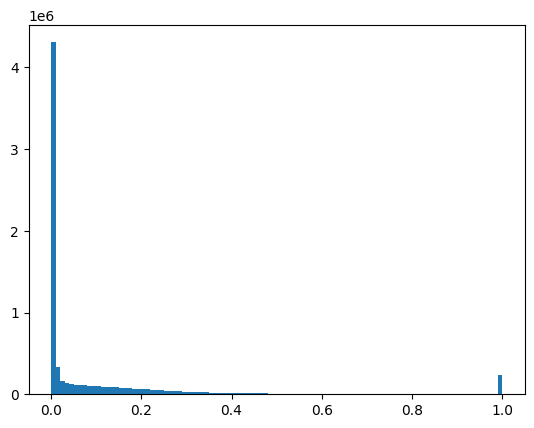

In [21]:
#
pred_labelsx=[1 if x>0. else 0 for x in pred_probax]  #
attention_scorex_t=attention_scorex[np.array([i==1 for i in pred_labelsx])]
# attention_scorex_tx=rm_outlier(attention_scorex_t)
attention_scorex_tx=adjust_value(attention_scorex_t)
attention_scorex_tx=do_scale(attention_scorex_tx)

plt.hist(attention_scorex_tx.flatten(),bins=100)

Text(0.5, 1.0, 'GM12878_CTCF')

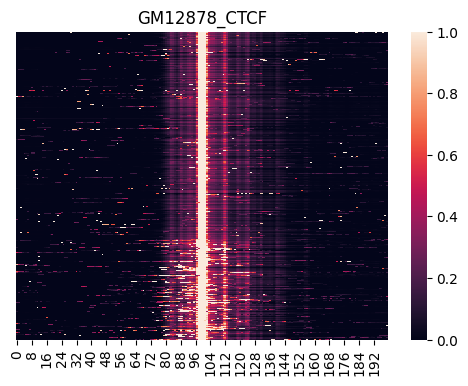

In [22]:
#
plt.ion()  # interactive mode
attention_scorex_td=pd.DataFrame(attention_scorex_tx)
if len(attention_scorex_td)>2000:
    attention_scorex_td=attention_scorex_td.sample(n=2000)

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

attention_scorex_kc,kc_labels=make_cluster(attention_scorex_td,nc=2)
sns.heatmap(attention_scorex_kc,yticklabels=False,ax=axes)  
plt.title(cell+'_'+tranf)


Text(0, 0.5, '')

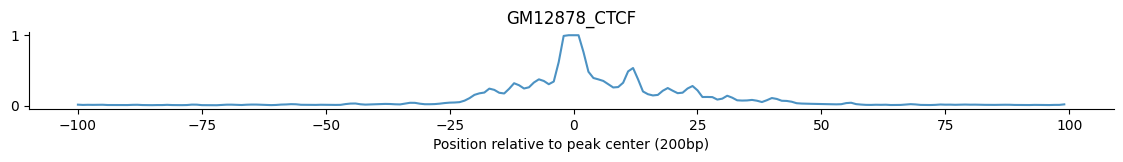

In [23]:
attention_scorex_kc_n=attention_scorex_kc.values
attention_scorex_ty=pd.DataFrame(
    { 'position':[i for i in range(-100,100)],
      'attention_score':attention_scorex_kc_n.mean(axis=0).tolist(),}
)

#attention_scorex_ty=attention_scorex_ty.melt(id_vars=['position'],value_name='attention_score')

fig, axes = plt.subplots(1, 1, figsize=(14, 1))
sns.lineplot(x="position", y="attention_score", data=attention_scorex_ty,legend=None,alpha=0.8,)
sns.despine()
plt.title(cell+'_'+tranf)
plt.xlabel('Position relative to peak center (200bp)')
plt.ylabel('')


In [ ]:
## Extract motif from CNN module
# NeuronMotif (https://www.pnas.org/doi/10.1073/pnas.2216698120) is used to extract the motifs learned by EIformer 

In [24]:
#define demo model
def create_model(conv_layer):
    input = tf.keras.Input(shape=(200, 4))
    x = conv_layer(input)
    x=tf.keras.layers.Activation('relu')(x)
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(units=1)(x)
    output = tf.keras.layers.Activation('sigmoid')(x)
    model = tf.keras.Model(input, output,)
    return model

In [26]:
vocab_size=3**7
d_model = 32
len_motif=12
dff = 128
num_heads = 1
num_layers = 1
dropout_rate = 0.1

dna_in=tf.keras.Input((200,4))
epi_in=tf.keras.Input((200,))

_ = epiformer((dna_in,epi_in))  #Call the Model first, then load the weights.
epiformer.load_weights(file_weight) #
    
initial_weights=epiformer.weights[17].numpy()
initial_biases=epiformer.weights[18].numpy()
        
xi=tf.keras.Input(shape=(200, 4))
conv_layer=tf.keras.layers.Conv1D(24, 12,trainable=False)  #
xo=conv_layer(xi)
conv_layer.set_weights([initial_weights,initial_biases])  #  
demonet=create_model(conv_layer)

w_demonet=file_weight[:-3]+'_demonet.h5'
demonet.save_weights(w_demonet)